# Train Blending (BERT cased, DistilBERT uncased, DeBERTa)

Best F1 score BERT model on HS_C dataset are used

In [1]:
# This automates data tabulation onto google sheets 

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis'

# Change the current working directory
os.chdir(new_directory)

# Use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('thesis-432315-12daec8d1ff6.json', scope)

service = build('sheets', 'v4', credentials=creds)

client = gspread.authorize(creds)

spreadsheet_id = '1wKr9B0W-j7C-38o-DoQY_ldR7Leroua-RaDHG3Mbkf0' 

## Load Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis/Development'

# Change the current working directory
os.chdir(new_directory)

# Adjust file paths to local system
file_path = 'Corpus/data_b.csv'
df = pd.read_csv(file_path)

# Split the data
holdout_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Load Models and Tokenizers

In [3]:
def load_model_and_tokenizer(model_path, tokenizer_path, base_model):
    # Load the tokenizer from the local directory
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Load the configuration from the base model
    config = AutoConfig.from_pretrained(base_model, num_labels=2)

    # Initialize the model with the configuration
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

    # Ensure the model is in evaluation mode
    model.eval()
    
    return model, tokenizer

model_info = {

    'HateBERT': {
        'model_path': 'BERT models/hs_HateBERT-finetuned',
        'tokenizer_path': 'BERT models/hs_HateBERT-finetuned',
        'base_model': 'GroNLP/hateBERT'
    },

    'TagBERT': {
        'model_path': 'BERT models/hs_Tag-Roberta-finetuned',
        'tokenizer_path': 'BERT models/hs_Tag-Roberta-finetuned',
        'base_model': 'jcblaise/roberta-tagalog-base'
    },

    'DeBERTa': {
        'model_path': 'BERT models/hs_DeBERTa-finetuned',
        'tokenizer_path': 'BERT models/hs_DeBERTa-finetuned',
        'base_model': 'microsoft/deberta-v3-base'
    },

    'DistilBERT uncased': {
        'model_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'tokenizer_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'base_model': 'distilbert/distilbert-base-uncased'
    },
    
    'fBERT': {
        'model_path': 'BERT models/hs_fBERT-finetuned',
        'tokenizer_path': 'BERT models/hs_fBERT-finetuned',
        'base_model': 'diptanu/fBERT'
    },
    

}

models_and_tokenizers = {name: load_model_and_tokenizer(info['model_path'], 
                                                        info['tokenizer_path'], 
                                                        info['base_model']) 
                         for name, info in model_info.items()}

## Apply Tokenization

In [4]:
def texts_to_dataloader(texts, tokenizer, batch_size=32):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

## Perform Blending

In [5]:
%load_ext memory_profiler

In [6]:
%%memit

def get_meta_features(model, tokenizer, df, device):
    texts = df['text'].tolist()
    dataloader = texts_to_dataloader(texts, tokenizer, batch_size=32)
    
    model.to(device)
    model.eval()
    meta_features = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            meta_features.append(probs.cpu().numpy())
    return np.concatenate(meta_features)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Generate meta-features for holdout and test sets
holdout_meta_features = [get_meta_features(model, tokenizer, holdout_df, device) for model, tokenizer in models_and_tokenizers.values()]
test_meta_features = [get_meta_features(model, tokenizer, test_df, device) for model, tokenizer in models_and_tokenizers.values()]

# Stack meta-features
holdout_meta_features = np.hstack(holdout_meta_features)
test_meta_features = np.hstack(test_meta_features)

peak memory: 2998.53 MiB, increment: 213.08 MiB


In [7]:
# Check the base model predictions
for name, (model, tokenizer) in models_and_tokenizers.items():
    print(f"Checking base model predictions for {name}...")
    base_model_preds = get_meta_features(model, tokenizer, test_df, device)
    print("Predictions distribution:", np.mean(base_model_preds, axis=0))

Checking base model predictions for HateBERT...
Predictions distribution: [0.48031706 0.51968306]
Checking base model predictions for TagBERT...
Predictions distribution: [0.53198415 0.46801585]
Checking base model predictions for DeBERTa...
Predictions distribution: [0.4875323  0.51246786]
Checking base model predictions for DistilBERT uncased...
Predictions distribution: [0.48721948 0.5127806 ]
Checking base model predictions for fBERT...
Predictions distribution: [0.6126724  0.38732833]


### Train LR

In [15]:
%%memit
# Train the LR meta-classifier
lr_meta_classifier = LogisticRegression()
lr_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

lr_final_predictions = lr_meta_classifier.predict(test_meta_features)

/opt/anaconda3/envs/thesis/lib/python3.10/multiprocessing/resource_tracker.py:104: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disa

peak memory: 2581.25 MiB, increment: 1.19 MiB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Train NB

In [16]:
%%memit
# Train the NB meta-classifier
nb_meta_classifier = GaussianNB()
nb_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

nb_final_predictions = nb_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 2581.34 MiB, increment: 0.08 MiB


### Train DT

In [17]:
%%memit
# Train the DT meta-classifier
dt_meta_classifier = DecisionTreeClassifier(max_depth=None)  
dt_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

dt_final_predictions = dt_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2581.53 MiB, increment: 0.19 MiB


### Train SVM

In [23]:
%%memit
# Train the SVM meta-classifier
svm_meta_classifier = SVC(kernel='linear', probability=True)
svm_meta_classifier.fit(holdout_meta_features, holdout_df['label'].values)

svm_final_predictions = svm_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2639.27 MiB, increment: 44.69 MiB


## Evaluate Models

### LR

In [12]:
# Evaluate
precision = precision_score(test_df['label'].values, lr_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, lr_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, lr_final_predictions)
f1 = f1_score(test_df['label'].values, lr_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, lr_final_predictions)

print("Logistic Regression")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Logistic Regression
Precision: 0.7912
Recall: 0.7822
Ensemble accuracy: 0.8055
F1 Score: 0.7866
Confusion Matrix:
[[1114  236]
 [ 249  894]]


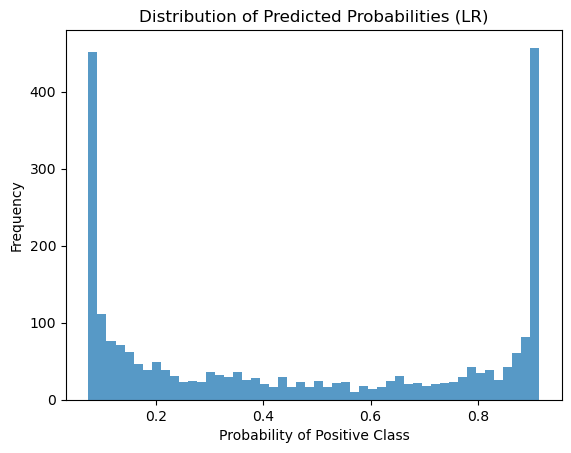

In [13]:
# Get probability scores for the positive class
lr_prob_scores = lr_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], lr_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (lr_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)


print(f"Adjusted threshold: {best_thresh:.4f}")
print("Adjusted Logistic Regression")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

lr_thresh = best_thresh

Adjusted threshold: 0.4000
Adjusted Logistic Regression
Precision: 0.7594
Recall: 0.8338
Accuracy: 0.8026
F1 Score: 0.7948
Confusion Matrix:
[[1048  302]
 [ 190  953]]


In [15]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!B8:E8'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### NB

In [16]:
# Evaluate
precision = precision_score(test_df['label'].values, nb_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, nb_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, nb_final_predictions)
f1 = f1_score(test_df['label'].values, nb_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, nb_final_predictions)

print("Naive Bayes")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Naive Bayes
Precision: 0.7817
Recall: 0.7865266841644795
Ensemble accuracy: 0.8014
F1 Score: 0.7841
Confusion Matrix:
[[1099  251]
 [ 244  899]]


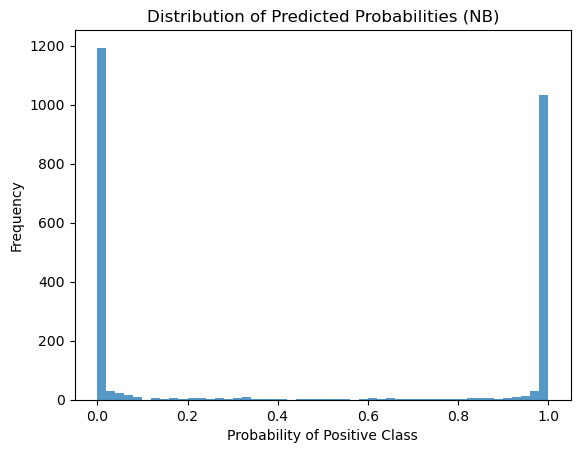

In [17]:
# Get probability scores for the positive class
nb_prob_scores = nb_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(nb_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (NB)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], nb_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (nb_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh:.4f}")
print("Adjusted Naive Bayes")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

nb_thresh = best_thresh

Adjusted threshold: 0.1000
Adjusted Naive Bayes
Precision: 0.7666
Recall: 0.8189
Accuracy: 0.8026
F1 Score: 0.7919
Confusion Matrix:
[[1065  285]
 [ 207  936]]


In [19]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!B9:E9'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### DT

In [20]:
# Evaluate
precision = precision_score(test_df['label'].values, dt_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, dt_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, dt_final_predictions)
f1 = f1_score(test_df['label'].values, dt_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, dt_final_predictions)

print("Decision Tree")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Decision Tree
Precision: 0.7074
Recall: 0.7087
Ensemble accuracy: 0.7320
F1 Score: 0.7080
Confusion Matrix:
[[1015  335]
 [ 333  810]]


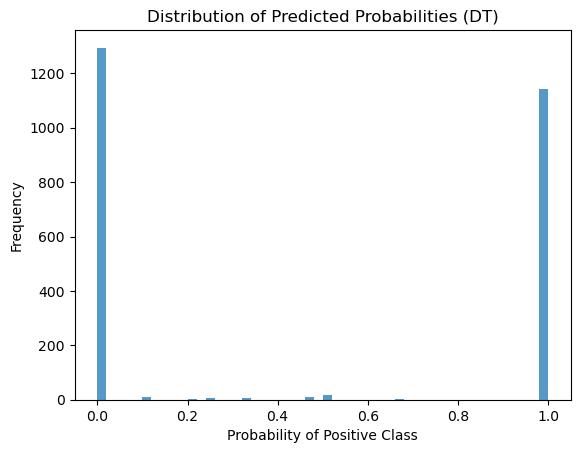

In [21]:
# Get probability scores for the positive class
dt_prob_scores = dt_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(dt_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (DT)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], dt_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (dt_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh:.4f}")
print("Adjusted Decision Tree")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

dt_thresh = best_thresh

Adjusted threshold: 0.3400
Adjusted Decision Tree
Precision: 0.7033
Recall: 0.7218
Accuracy: 0.7329
F1 Score: 0.7124
Confusion Matrix:
[[1002  348]
 [ 318  825]]


In [23]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!B10:E10'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### SVM

In [24]:
# Evaluate
precision = precision_score(test_df['label'].values, svm_final_predictions, average='binary')
recall = recall_score(test_df['label'].values, svm_final_predictions, average='binary')
accuracy = accuracy_score(test_df['label'].values, svm_final_predictions)
f1 = f1_score(test_df['label'].values, svm_final_predictions, average='binary')
conf_matrix = confusion_matrix(test_df['label'].values, svm_final_predictions)

print("SVM")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Ensemble accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

SVM
Precision: 0.8068
Recall: 0.7638
Ensemble accuracy: 0.8079
F1 Score: 0.7847
Confusion Matrix:
[[1141  209]
 [ 270  873]]


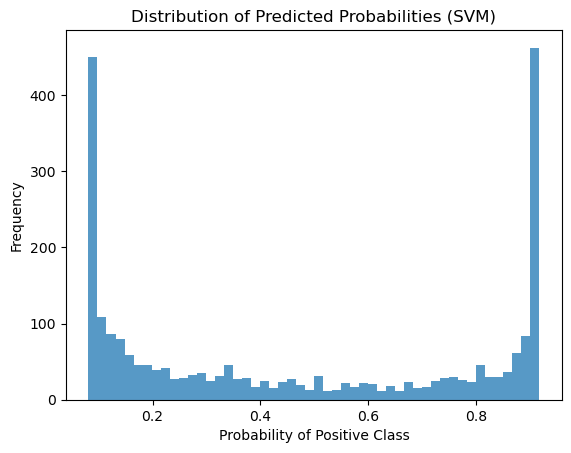

In [25]:
# Get probability scores for the positive class
svm_prob_scores = svm_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(svm_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Determine a new threshold
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(test_df['label'], svm_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]

# Apply the new threshold
adjusted_predictions = (svm_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_recall = recall_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(test_df['label'], adjusted_predictions)
adjusted_f1 = f1_score(test_df['label'], adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(test_df['label'], adjusted_predictions)

print(f"Adjusted threshold: {best_thresh:.4f}")
print("Adjusted SVM")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

svm_thresh = best_thresh

Adjusted threshold: 0.3600
Adjusted SVM
Precision: 0.7510
Recall: 0.8495
Accuracy: 0.8018
F1 Score: 0.7972
Confusion Matrix:
[[1028  322]
 [ 172  971]]


In [27]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!B11:E11'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


# Validate on Data C

## Load Data C Dataset

In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load validation data
validation_file_path = 'Corpus/data_c.csv'
validation_df = pd.read_csv(validation_file_path)

## Perform Blending

In [19]:
%%memit

# Generate meta-features for validation set
validation_meta_features = [get_meta_features(model, tokenizer, validation_df, device) 
                            for model, tokenizer in models_and_tokenizers.values()]

# Stack meta-features
validation_meta_features = np.hstack(validation_meta_features)

# Predict with LR meta-classifier
lr_validation_predictions = lr_meta_classifier.predict(validation_meta_features)

# Predict with NB meta-classifier
nb_validation_predictions = nb_meta_classifier.predict(validation_meta_features)

# Predict with DT meta-classifier
dt_validation_predictions = dt_meta_classifier.predict(validation_meta_features)

# Predict with SVM meta-classifier
svm_validation_predictions = svm_meta_classifier.predict(validation_meta_features)

# Extract true labels from the validation set
true_labels = validation_df['label'].values

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 2597.14 MiB, increment: 15.42 MiB


## Validate Models

### LR

In [1]:
# Calculate metrics
accuracy = accuracy_score(true_labels, lr_validation_predictions)
precision = precision_score(true_labels, lr_validation_predictions, average='binary')
recall = recall_score(true_labels, lr_validation_predictions, average='binary')
f1 = f1_score(true_labels, lr_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, lr_validation_predictions)

# Print the metrics
print("Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

NameError: name 'accuracy_score' is not defined

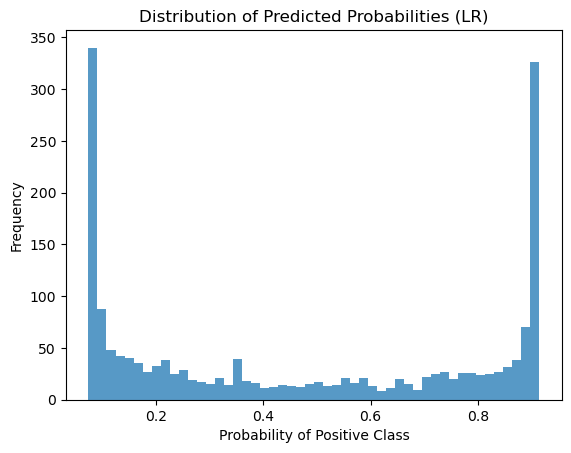

In [31]:
# Get probability scores for the positive class
lr_prob_scores = lr_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized LR

In [32]:
# Apply the new threshold
adjusted_predictions = (lr_prob_scores >= lr_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(true_labels, adjusted_predictions, average='binary')
adjusted_recall = recall_score(true_labels, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(true_labels, adjusted_predictions)
adjusted_f1 = f1_score(true_labels, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(true_labels, adjusted_predictions)

print("Optimized Logistic Regression")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Logistic Regression
Precision: 0.7681
Recall: 0.8395
Accuracy: 0.8073
F1 Score: 0.8022
Confusion Matrix:
[[769 218]
 [138 722]]


In [33]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!F8:I8'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [34]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 5B-3 LR'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [35]:

# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 5B-3 LR.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/OH_Using_HS 5B-3 LR.png


In [36]:
import pandas as pd

folder_path = os.path.expanduser('Results/ERROR ANALYSIS/HS/BLD/')

# Create a DataFrame 
results_df = pd.DataFrame({
    'Text': validation_df['text'],
    'True Label': validation_df['label'],
    'Predicted Label': adjusted_predictions
})

# Extract misclassified instances
false_positives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 1)]
false_negatives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 0)]

false_positives.to_csv(os.path.join(folder_path, '5BLD-3-LR_false_positives.csv'), index=False)
false_negatives.to_csv(os.path.join(folder_path, '5BLD-3-LR_false_negatives.csv'), index=False)

### NB

In [37]:
# Calculate metrics
accuracy = accuracy_score(true_labels, nb_validation_predictions)
precision = precision_score(true_labels, nb_validation_predictions, average='binary')
recall = recall_score(true_labels, nb_validation_predictions, average='binary')
f1 = f1_score(true_labels, nb_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, nb_validation_predictions)

# Print the metrics
print("Naive Bayes")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Naive Bayes
Accuracy: 0.8078
Precision: 0.7886
Recall: 0.8023
F1 Score: 0.7954
Confusion Matrix:
 [[802 185]
 [170 690]]


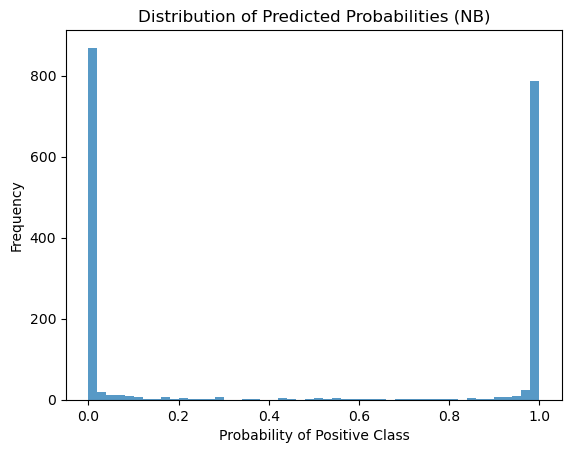

In [38]:
# Get probability scores for the positive class
nb_prob_scores = nb_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(nb_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (NB)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized NB

In [39]:
# Apply the new threshold
adjusted_predictions = (nb_prob_scores >= nb_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(true_labels, adjusted_predictions, average='binary')
adjusted_recall = recall_score(true_labels, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(true_labels, adjusted_predictions)
adjusted_f1 = f1_score(true_labels, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(true_labels, adjusted_predictions)

print("Optimized Naive Bayes")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Naive Bayes
Precision: 0.7681
Recall: 0.8279
Accuracy: 0.8035
F1 Score: 0.7969
Confusion Matrix:
[[772 215]
 [148 712]]


In [40]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!F9:I9'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [41]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 5B-3 NB'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [42]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 5B-3 NB.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/OH_Using_HS 5B-3 NB.png


In [43]:
import pandas as pd

folder_path = os.path.expanduser('Results/ERROR ANALYSIS/HS/BLD/')

# Create a DataFrame 
results_df = pd.DataFrame({
    'Text': validation_df['text'],
    'True Label': validation_df['label'],
    'Predicted Label': adjusted_predictions
})

# Extract misclassified instances
false_positives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 1)]
false_negatives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 0)]

false_positives.to_csv(os.path.join(folder_path, '5BLD-3-NB_false_positives.csv'), index=False)
false_negatives.to_csv(os.path.join(folder_path, '5BLD-3-NB_false_negatives.csv'), index=False)

### DT

In [44]:
# Calculate metrics
accuracy = accuracy_score(true_labels, dt_validation_predictions)
precision = precision_score(true_labels, dt_validation_predictions, average='binary')
recall = recall_score(true_labels, dt_validation_predictions, average='binary')
f1 = f1_score(true_labels, dt_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, dt_validation_predictions)

# Print the metrics
print("Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Decision Tree
Accuracy: 0.7250
Precision: 0.7037
Recall: 0.7070
F1 Score: 0.7053
Confusion Matrix:
 [[731 256]
 [252 608]]


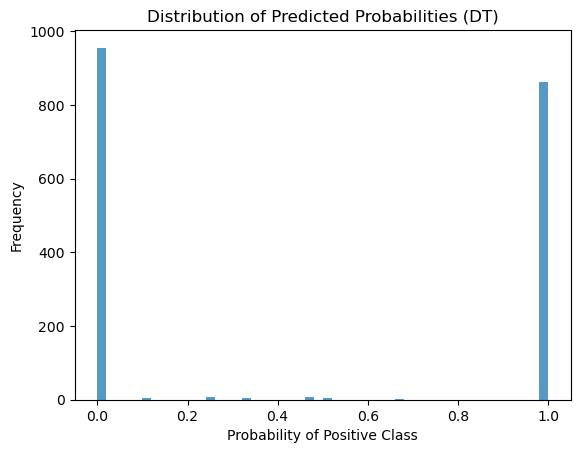

In [45]:
# Get probability scores for the positive class
dt_prob_scores = dt_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(dt_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (DT)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized DT

In [46]:
# Apply the new threshold
adjusted_predictions = (dt_prob_scores >= dt_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(true_labels, adjusted_predictions, average='binary')
adjusted_recall = recall_score(true_labels, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(true_labels, adjusted_predictions)
adjusted_f1 = f1_score(true_labels, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(true_labels, adjusted_predictions)

print("Optimized Decision Tree")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized Decision Tree
Precision: 0.6975
Recall: 0.7105
Accuracy: 0.7217
F1 Score: 0.7039
Confusion Matrix:
[[722 265]
 [249 611]]


In [47]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!F10:I10'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [48]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 5B-3 DT'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [49]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 5B-3 DT.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/OH_Using_HS 5B-3 DT.png


In [50]:
import pandas as pd

folder_path = os.path.expanduser('Results/ERROR ANALYSIS/HS/BLD/')

# Create a DataFrame 
results_df = pd.DataFrame({
    'Text': validation_df['text'],
    'True Label': validation_df['label'],
    'Predicted Label': adjusted_predictions
})

# Extract misclassified instances
false_positives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 1)]
false_negatives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 0)]

false_positives.to_csv(os.path.join(folder_path, '5BLD-3-DT_false_positives.csv'), index=False)
false_negatives.to_csv(os.path.join(folder_path, '5BLD-3-DT_false_negatives.csv'), index=False)

### SVM

In [27]:
# Calculate metrics
accuracy = accuracy_score(true_labels, svm_validation_predictions)
precision = precision_score(true_labels, svm_validation_predictions, average='binary')
recall = recall_score(true_labels, svm_validation_predictions, average='binary')
f1 = f1_score(true_labels, svm_validation_predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, svm_validation_predictions)

# Print the metrics
print("SVM")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

SVM
Accuracy: 0.8008
Precision: 0.7964
Recall: 0.7686
F1 Score: 0.7822
Confusion Matrix:
 [[818 169]
 [199 661]]


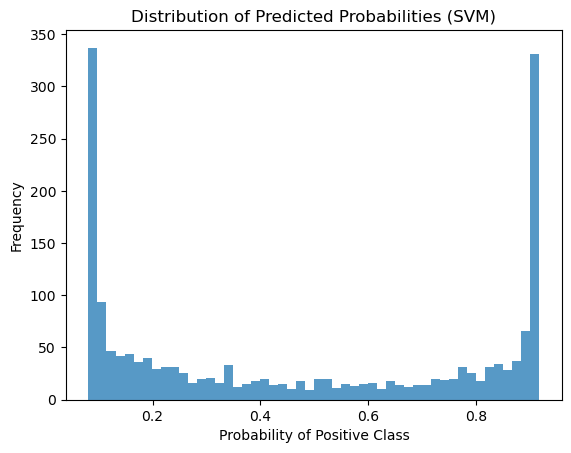

In [28]:
# Get probability scores for the positive class
svm_prob_scores = svm_meta_classifier.predict_proba(validation_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(svm_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

#### Optimized SVM

In [29]:
# Apply the new threshold
adjusted_predictions = (svm_prob_scores >= svm_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(true_labels, adjusted_predictions, average='binary')
adjusted_recall = recall_score(true_labels, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(true_labels, adjusted_predictions)
adjusted_f1 = f1_score(true_labels, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(true_labels, adjusted_predictions)

print("Optimized SVM")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Optimized SVM
Precision: 0.7575
Recall: 0.8570
Accuracy: 0.8056
F1 Score: 0.8041
Confusion Matrix:
[[751 236]
 [123 737]]


In [30]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '5-3!F11:I11'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save Confusion Matrix

In [31]:
import altair as alt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 5B-3 SVM'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [32]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 5B-3 SVM.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Blending/OH_Using_HS 5B-3 SVM.png


In [36]:
import pandas as pd

folder_path = os.path.expanduser('Results/ERROR ANALYSIS/HS/BLD/')

import pandas as pd

# Step 1: Extract the necessary columns
texts = validation_df['text']
true_labels = validation_df['label']

# Step 2: Create a new DataFrame with the required columns
results_df = pd.DataFrame({
    'text': texts,
    'predicted_label': adjusted_predictions,
    'true_label': true_labels
})

# Step 3: Save the DataFrame to a CSV file
results_df.to_csv(os.path.join(folder_path, '5BLD-3-SVM_predictions.csv'), index=False)

print("Prediction results saved to '5BLD-3-SVM_predictions.csv'.")

Prediction results saved to '5BLD-3-SVM_predictions.csv'.


In [57]:
import pandas as pd

folder_path = os.path.expanduser('Results/ERROR ANALYSIS/HS/BLD/')

# Create a DataFrame 
results_df = pd.DataFrame({
    'Text': validation_df['text'],
    'True Label': validation_df['label'],
    'Predicted Label': adjusted_predictions
})

# Extract misclassified instances
false_positives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 1)]
false_negatives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 0)]

false_positives.to_csv(os.path.join(folder_path, '5BLD-3-SVM_false_positives.csv'), index=False)
false_negatives.to_csv(os.path.join(folder_path, '5BLD-3-SVM_false_negatives.csv'), index=False)